# Diffusion + WGAN experiments
This is the main script for experiments related to combining diffusion with
WGAN-based loss within the same training loop.

In [2]:
# imports

# pretend we are in the root folder:
import sys
sys.path.append("../")

from udl_module.datasets import dataset_factory
from udl_module.nn import unet_factory
from udl_module.vincent_diffusion import DiffusionModel

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, MNIST

import lightning as L

/home/vincent/miniforge3/envs/pytorch_base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Development
Will paste stuff above once it works :-)

In [ ]:
# Creating the datasets:

trainset, testset = dataset_factory(CIFAR10)

batch_size = 32
dl_kwargs = {
    "batch_size": batch_size, "shuffle": True, "num_workers": 4, "pin_memory": True,
}

trainloader = DataLoader(
    trainset, **dl_kwargs
)
testloader = DataLoader(
    testset, **dl_kwargs
)

In [4]:
from torch import nn

# From: https://github.com/Zeleni9/pytorch-wgan/blob/e594e2eef7dbd82d6ad23e9442006f6aee08db6e/models/wgan_gradient_penalty.py
class Generator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [1024, 512, 256]
        # Input_dim = 100
        # Output_dim = C (number of channels)
        self.main_module = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=256, out_channels=channels, kernel_size=4, stride=2, padding=1))
            # output of main module --> Image (Cx32x32)

        self.output = nn.Tanh()

    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

class Discriminator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [256, 512, 1024]
        # Input_dim = channels (Cx64x64)
        # Output_dim = 1
        self.main_module = nn.Sequential(
            # Omitting batch normalization in critic because our new penalized training objective (WGAN with gradient penalty) is no longer valid
            # in this setting, since we penalize the norm of the critic's gradient with respect to each input independently and not the enitre batch.
            # There is not good & fast implementation of layer normalization --> using per instance normalization nn.InstanceNorm2d()
            # Image (Cx32x32)
            nn.Conv2d(in_channels=channels, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True))
            # output of main module --> State (1024x4x4)

        self.output = nn.Sequential(
            # The output of D is no longer a probability, we do not apply sigmoid at the output of D.
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0))


    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

    def feature_extraction(self, x):
        # Use discriminator for feature extraction then flatten to vector of 16384
        x = self.main_module(x)
        return x.view(-1, 1024*4*4)

In [ ]:
class WGANWithGradientPenaltyFuncs:
    """Encapsulates all computations specific to the Wasserstein GAN with
    Gradient Penalty instead of weight clipping.
    """

    def __init__(self, gp_weight: float = 10, critic_iterations: int = 5):
        """
        Args:
            gp_weight: scale factor for gradient penalty term in critic loss.
            critic_iterations: this many critic learning steps for every one
                generator learning step. -1 Means never called at all.
        """
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
    
    def also_train_generator(self, batch_idx):
        """Given the batch index, checks if it is time to train the generator
        again."""
        if self.critic_iterations == -1:
            return False
        return (batch_idx % self.critic_iterations) == 0
    
    def critic_loss(self, critic_model, batch, fake_imgs):
        """Returns loss for the critic model."""
        fake_imgs = fake_imgs.detach() # just to be sure :-p

        critic_real = critic_model(batch)
        critic_fake = critic_model(fake_imgs)
        grad_pen = self.compute_gradient_penalty(critic_model, batch, fake_imgs)

        # Calculating the Wasserstein loss:
        return (
            - torch.mean(critic_real)
            + torch.mean(critic_fake)
            + self.gp_weight * grad_pen
        )
    
    def generator_loss(self, critic_model, fake_imgs):
        """Returns loss for the generator. Should only be called when
        `also_train_generator()` returns `True`
        """
        critic_fake = critic_model(fake_imgs)
        return -torch.mean(critic_fake)

    def compute_gradient_penalty(self, critic_model, real, fake):
        # Get critic outputs on random mix of real and fake images
        alpha = torch.rand(real.shape[0], *([1] * (len(real.shape) - 1)),
                           device=real.device)
        mixed = alpha * real + (1 - alpha) * fake
        mixed.requires_grad_(True)
        critic_mixed = critic_model(mixed)

        # Compute gradients of 
        gradients = torch.autograd.grad(
            inputs=mixed,
            outputs=critic_mixed,
            grad_outputs=torch.ones_like(critic_mixed),
            create_graph=True, retain_graph=True
        )[0].view(real.shape[0], -1)

        # Returning the gradient penalty:
        return (torch.mean(gradients.norm(2, dim=1) - 1) ** 2)

In [ ]:
class WGANWithGradientPenalty(L.LightningModule):
    """Wasserstein Gan that uses Gradient Penalty instead of weight clipping."""

    def __init__(
            self,
            generator: nn.Module,
            critic: nn.Module,
            gp_weight: float = 10,
            critic_iterations: int = 5,
            optimizer_cls: type[torch.optim.Optimizer] = torch.optim.Adam,
            optimizer_args: dict = {"lr": 1e-4, "betas": (0.5, 0.99)}
    ):
        super().__init__()
        self.gen = generator
        self.cri = critic
        self.wgan_funcs = WGANWithGradientPenaltyFuncs(gp_weight, critic_iterations)
        self.optimizer_cls = optimizer_cls
        self.optimizer_args = optimizer_args

        self.automatic_optimization = False
    
    def forward(self, x):
        return self.gen(x)

    def training_step(self, batch, batch_idx):
        opt_g, opt_c = self.optimizers()

        self.toggle_optimizer(opt_c)

        # Creating fake images
        with torch.no_grad():
            noise = torch.randn((batch.shape[0], 100, 1, 1), device=self.device)
            fake_imgs = self.gen(noise)
        
        loss_critic = self.wgan_funcs.critic_loss(self.cri, batch, fake_imgs)

        # Weight update:
        opt_c.zero_grad()
        self.manual_backward(loss_critic)
        opt_c.step()
        self.log("train/loss_critic", loss_critic, prog_bar=True)

        self.untoggle_optimizer(opt_c) # not really sure if needed but well..
        
        also_train_generator = self.wgan_funcs.also_train_generator(batch_idx)

        if also_train_generator:
            self.toggle_optimizer(opt_g)

            # Generate images (TODO: maybe can re-use from discriminator step)
            noise = torch.randn((batch.shape[0], 100, 1, 1), device=self.device)
            fake_imgs = self.gen(noise)
            # critic_fake = self.cri(fake_imgs)
            # loss_gen = - torch.mean(critic_fake)
            loss_gen = self.wgan_funcs.generator_loss(self.cri, fake_imgs)

            # Weight update:
            opt_g.zero_grad()
            self.manual_backward(loss_gen)
            opt_g.step()
            
            self.log("train/loss_generator", loss_gen, prog_bar=True)

            self.untoggle_optimizer(opt_g)
    
    def configure_optimizers(self):
        opt_g = self.optimizer_cls(self.gen.parameters(), **self.optimizer_args)
        opt_c = self.optimizer_cls(self.cri.parameters(), **self.optimizer_args)
        return opt_g, opt_c

import numpy as np
torch.manual_seed(1996)
np.random.seed(1996)

# Creating the datasets:
trainset, testset = dataset_factory(CIFAR10)

batch_size = 64
dl_kwargs = {
    "batch_size": batch_size, "shuffle": True, "num_workers": 4, "pin_memory": True,
}

trainloader = DataLoader(
    trainset, **dl_kwargs
)

img_size = (32,32,3)

wgan = WGANWithGradientPenalty(
    Generator(3),
    Discriminator(3)
)

# Experiment
trainer = L.Trainer(
    max_time={"minutes": 5},
    max_epochs=1,
    # max_steps=100,
    enable_checkpointing=False,
    logger=False,
    enable_progress_bar=True,
    # accelerator="cpu",
    # fast_dev_run=True
)

trainer.fit(wgan, trainloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | gen  | Generator     | 12.1 M | train
1 | cri  | Discriminator | 10.5 M | train
-----------------------------------------------
22.7 M    Trainable params
0         Non-trainable params
22.7 M    Total params
90.647    Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 782/782 [01:29<00:00,  8.73it/s, train/loss_critic=-12.9, train/loss_generator=31.00]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 782/782 [01:29<00:00,  8.73it/s, train/loss_critic=-12.9, train/loss_generator=31.00]


83/782 [00:09<01:19,  8.81it/s, train/loss_critic=-35.4, train/loss_generator=44.40]

In [58]:
noise = torch.randn((5, 100, 1, 1))
fake_imgs = wgan.gen(noise).detach()

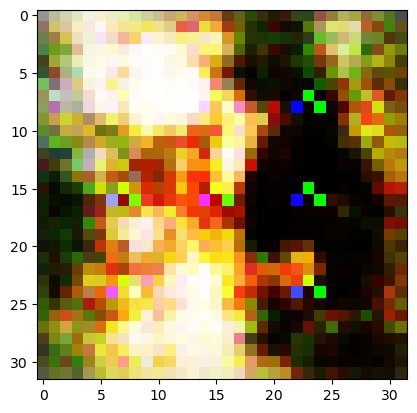

In [59]:
import matplotlib.pyplot as plt

plt.imshow(fake_imgs[4].transpose(0,2) * 0.5 + 0.5)

In [41]:
test_x = torch.ones((5,3,3))

test_y = torch.rand(5,1,1)

print(test_x * test_y)

tensor([[[0.5153, 0.5153, 0.5153],
         [0.5153, 0.5153, 0.5153],
         [0.5153, 0.5153, 0.5153]],

        [[0.3762, 0.3762, 0.3762],
         [0.3762, 0.3762, 0.3762],
         [0.3762, 0.3762, 0.3762]],

        [[0.5448, 0.5448, 0.5448],
         [0.5448, 0.5448, 0.5448],
         [0.5448, 0.5448, 0.5448]],

        [[0.3412, 0.3412, 0.3412],
         [0.3412, 0.3412, 0.3412],
         [0.3412, 0.3412, 0.3412]],

        [[0.7485, 0.7485, 0.7485],
         [0.7485, 0.7485, 0.7485],
         [0.7485, 0.7485, 0.7485]]])


In [ ]:
# import imageio
# import numpy as np
# import torch
# import torch.nn as nn
# from torchvision.utils import make_grid
# from torch.autograd import Variable
# from torch.autograd import grad as torch_grad


# class Trainer():
#     def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer,
#                  gp_weight=10, critic_iterations=5, print_every=50,
#                  use_cuda=False):
#         self.G = generator
#         self.G_opt = gen_optimizer
#         self.D = discriminator
#         self.D_opt = dis_optimizer
#         self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': []}
#         self.num_steps = 0
#         self.use_cuda = use_cuda
#         self.gp_weight = gp_weight
#         self.critic_iterations = critic_iterations
#         self.print_every = print_every

#         if self.use_cuda:
#             self.G.cuda()
#             self.D.cuda()

#     def _critic_train_iteration(self, data):
#         """ """
#         # Get generated data
#         batch_size = data.size()[0]
#         generated_data = self.sample_generator(batch_size)

#         # Calculate probabilities on real and generated data
#         data = Variable(data)
#         if self.use_cuda:
#             data = data.cuda()
#         d_real = self.D(data)
#         d_generated = self.D(generated_data)

#         # Get gradient penalty
#         gradient_penalty = self._gradient_penalty(data, generated_data)
#         self.losses['GP'].append(gradient_penalty.data[0])

#         # Create total loss and optimize
#         self.D_opt.zero_grad()
#         d_loss = d_generated.mean() - d_real.mean() + gradient_penalty
#         d_loss.backward()

#         self.D_opt.step()

#         # Record loss
#         self.losses['D'].append(d_loss.data[0])

#     def _generator_train_iteration(self, data):
#         """ """
#         self.G_opt.zero_grad()

#         # Get generated data
#         batch_size = data.size()[0]
#         generated_data = self.sample_generator(batch_size)

#         # Calculate loss and optimize
#         d_generated = self.D(generated_data)
#         g_loss = - d_generated.mean()
#         g_loss.backward()
#         self.G_opt.step()

#         # Record loss
#         self.losses['G'].append(g_loss.data[0])

#     def _gradient_penalty(self, real_data, generated_data):
#         batch_size = real_data.size()[0]

#         # Calculate interpolation
#         alpha = torch.rand(batch_size, 1, 1, 1)
#         alpha = alpha.expand_as(real_data)
#         if self.use_cuda:
#             alpha = alpha.cuda()
#         interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
#         interpolated = Variable(interpolated, requires_grad=True)
#         if self.use_cuda:
#             interpolated = interpolated.cuda()

#         # Calculate probability of interpolated examples
#         prob_interpolated = self.D(interpolated)

#         # Calculate gradients of probabilities with respect to examples
#         gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
#                                grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
#                                prob_interpolated.size()),
#                                create_graph=True, retain_graph=True)[0]

#         # Gradients have shape (batch_size, num_channels, img_width, img_height),
#         # so flatten to easily take norm per example in batch
#         gradients = gradients.view(batch_size, -1)
#         self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data[0])

#         # Derivatives of the gradient close to 0 can cause problems because of
#         # the square root, so manually calculate norm and add epsilon
#         gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

#         # Return gradient penalty
#         return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

#     def _train_epoch(self, data_loader):
#         for i, data in enumerate(data_loader):
#             self.num_steps += 1
#             self._critic_train_iteration(data[0])
#             # Only update generator every |critic_iterations| iterations
#             if self.num_steps % self.critic_iterations == 0:
#                 self._generator_train_iteration(data[0])

#             if i % self.print_every == 0:
#                 print("Iteration {}".format(i + 1))
#                 print("D: {}".format(self.losses['D'][-1]))
#                 print("GP: {}".format(self.losses['GP'][-1]))
#                 print("Gradient norm: {}".format(self.losses['gradient_norm'][-1]))
#                 if self.num_steps > self.critic_iterations:
#                     print("G: {}".format(self.losses['G'][-1]))

#     def train(self, data_loader, epochs, save_training_gif=True):
#         if save_training_gif:
#             # Fix latents to see how image generation improves during training
#             fixed_latents = Variable(self.G.sample_latent(64))
#             if self.use_cuda:
#                 fixed_latents = fixed_latents.cuda()
#             training_progress_images = []

#         for epoch in range(epochs):
#             print("\nEpoch {}".format(epoch + 1))
#             self._train_epoch(data_loader)

#             if save_training_gif:
#                 # Generate batch of images and convert to grid
#                 img_grid = make_grid(self.G(fixed_latents).cpu().data)
#                 # Convert to numpy and transpose axes to fit imageio convention
#                 # i.e. (width, height, channels)
#                 img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
#                 # Add image grid to training progress
#                 training_progress_images.append(img_grid)

#         if save_training_gif:
#             imageio.mimsave('./training_{}_epochs.gif'.format(epochs),
#                             training_progress_images)

#     def sample_generator(self, num_samples):
#         latent_samples = Variable(self.G.sample_latent(num_samples))
#         if self.use_cuda:
#             latent_samples = latent_samples.cuda()
#         generated_data = self.G(latent_samples)
#         return generated_data

#     def sample(self, num_samples):
#         generated_data = self.sample_generator(num_samples)
#         # Remove color channel
#         return generated_data.data.cpu().numpy()[:, 0, :, :]